In [ ]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
!pip install -q jupyter_bbox_widget dataclasses-json supervision
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.5 MB/s eta 0:00:00


In [ ]:
import os
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor # ①

CHECKPOINT_PATH = "sam_vit_h_4b8939.pth"
MODEL_TYPE = "vit_h"
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device='cuda:0')

In [ ]:
import cv2
import supervision as sv

!wget https://raw.githubusercontent.com/Cobslab/imageBible/main/image/like_lenna.png

mask_generator = SamAutomaticMaskGenerator(sam)
IMAGE_NAME = "/content/like_lenna.png"
image_bgr = cv2.imread(IMAGE_NAME)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
sam_result = mask_generator.generate(image_rgb)
print(sam_result[0].keys())

--2024-01-19 06:24:46--  https://raw.githubusercontent.com/Cobslab/imageBible/main/image/like_lenna.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1462729 (1.4M) [image/png]
Saving to: ‘like_lenna.png’

like_lenna.png      100%[===================>]   1.39M  --.-KB/s    in 0.04s   

2024-01-19 06:24:46 (33.0 MB/s) - ‘like_lenna.png’ saved [1462729/1462729]

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


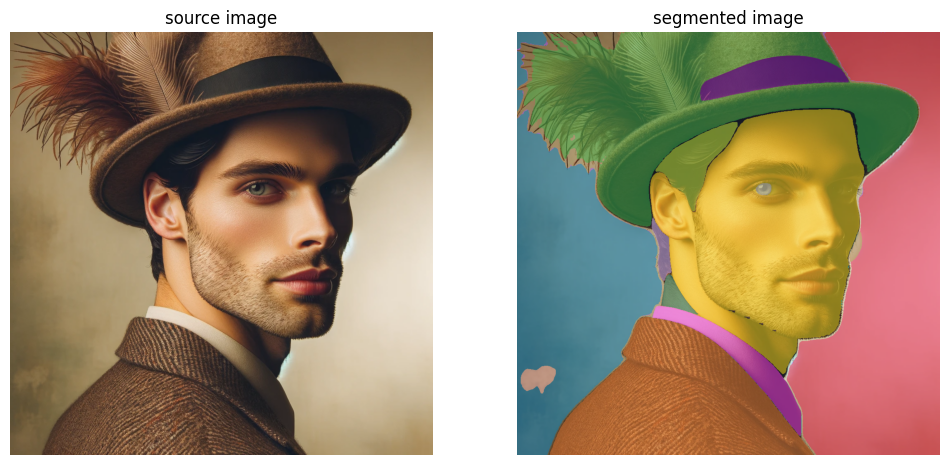

In [ ]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)
detections = sv.Detections.from_sam(sam_result=sam_result)
annotated_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)

sv.plot_images_grid(
    images=[image_bgr, annotated_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image'])

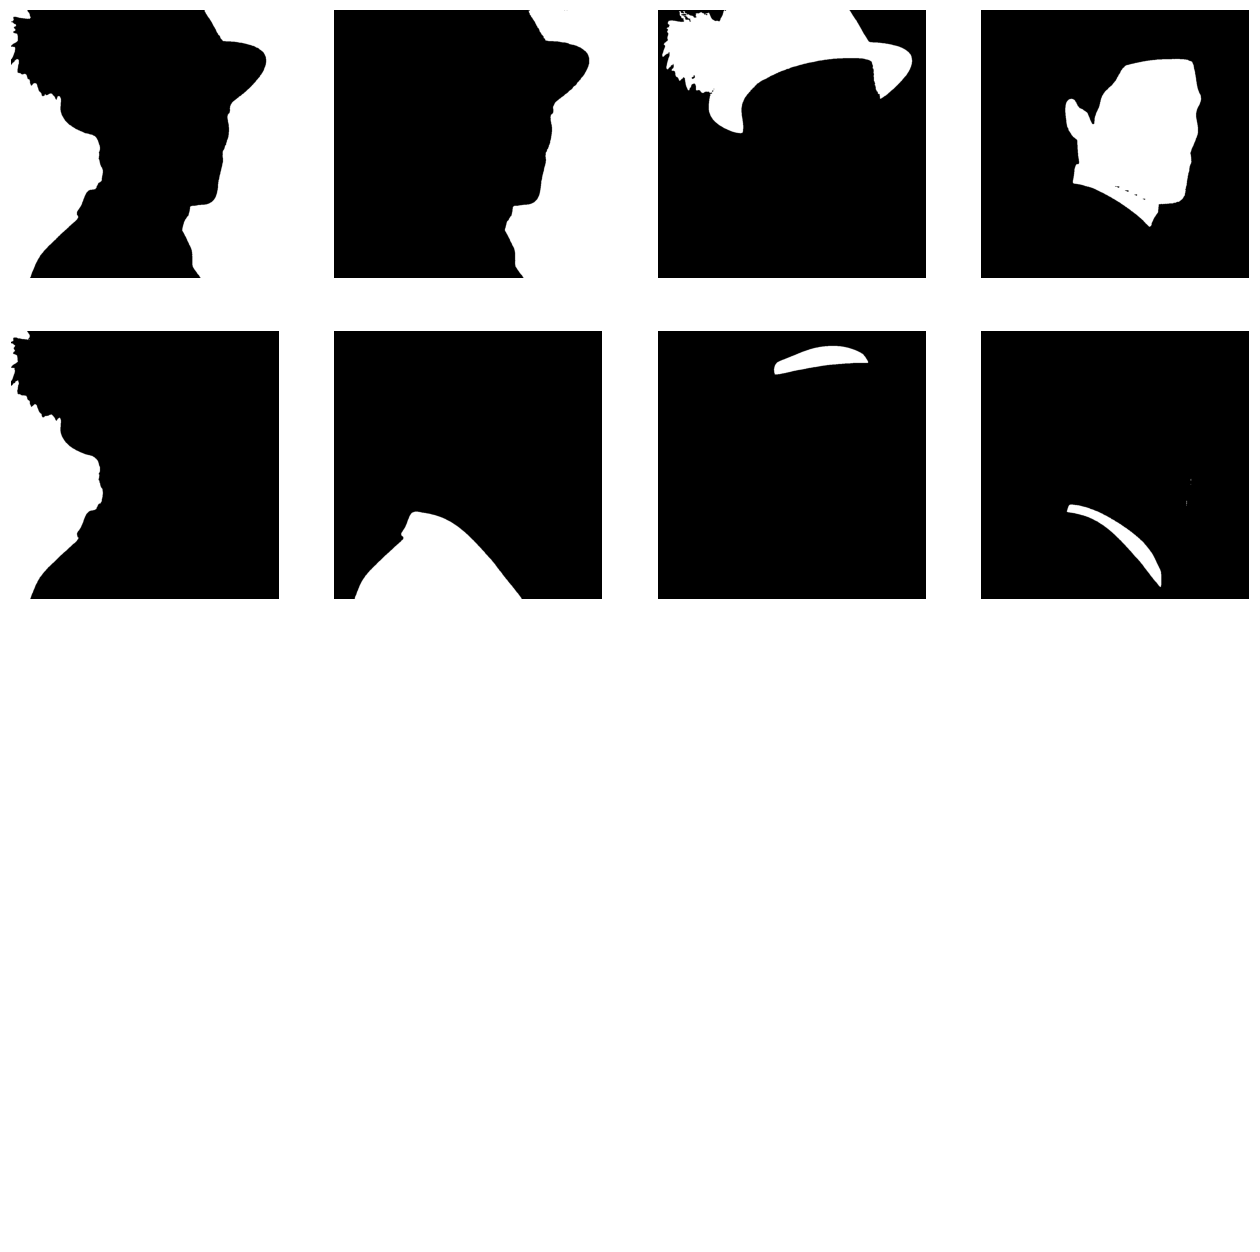

In [ ]:
masks = [mask['segmentation'] for mask in sorted(sam_result, key=lambda x: x['area'], reverse=True)[:8]]

sv.plot_images_grid(images=masks,grid_size=(4, 4),size=(16, 16))

In [ ]:
import base64
from google.colab import output
from jupyter_bbox_widget import BBoxWidget

def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

output.enable_custom_widget_manager()

widget = BBoxWidget()
widget.image = encode_image(IMAGE_NAME)
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
# 출력된 위 그림에 마우스로 드래그해서 영역을 지정해줘야 이 코드가 오류 없이 실행됩니다.
import numpy as np

print(widget.bboxes)
box = widget.bboxes[0]
box = np.array([box['x'], box['y'], box['x'] + box['width'], box['y'] + box['height']])

[{'x': 515, 'y': 542, 'width': 0, 'height': 0, 'label': ''}, {'x': 375, 'y': 205, 'width': 465, 'height': 489, 'label': ''}]


In [ ]:
mask_predictor = SamPredictor(sam)
image_bgr = cv2.imread(IMAGE_NAME)
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

mask_predictor.set_image(image_rgb)

masks, scores, logits = mask_predictor.predict(
    box=box,
    multimask_output=True)

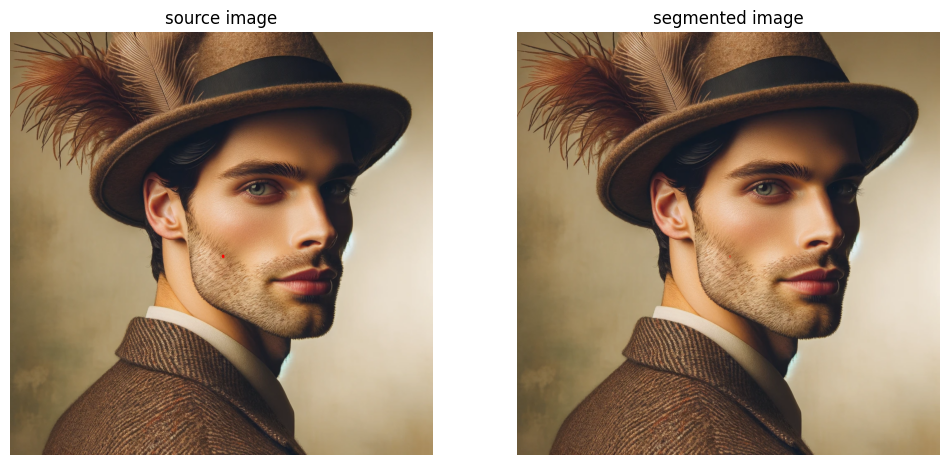

In [ ]:

box_annotator = sv.BoxAnnotator(color=sv.Color.red())
mask_annotator = sv.MaskAnnotator(color=sv.Color.red(), color_lookup=sv.ColorLookup.INDEX)

detections = sv.Detections(
xyxy=sv.mask_to_xyxy(masks=masks),mask=masks)
detections = detections[detections.area == np.max(detections.area)]
source_image = box_annotator.annotate(scene=image_bgr.copy(), detections=detections, skip_label=True)
segmented_image = mask_annotator.annotate(scene=image_bgr.copy(), detections=detections)
sv.plot_images_grid(
    images=[source_image, segmented_image],
    grid_size=(1, 2),
    titles=['source image', 'segmented image']
)